# Constants

In [28]:
import os
import requests
import zipfile
import subprocess as sbp
from pathlib import Path
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from dataclasses import dataclass
from typing import List, Dict, Optional
import json
# You can place this in a utilities cell/file.
import re
from datetime import datetime, timezone
from typing import Optional, Iterable
import pandas as pd
import json
import yaml
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd # Needed for pd.Timedelta


In [2]:
# change it to the path where you wanna put your data
BASE_PATH = Path("/home/ahmed.bargady/lustre/data_sec-um6p-st-sccs-6sevvl76uja/IDS/ahmed.bargady/datasets/temp/prod")
# BASE_PATH = Path("path_to_your_folder_of_work")

In [3]:
DATASETS = ['Linux24APT', 'russellmitchell', 'santos', 'wardbeck', 'shaw','wilson', 'fox']
len(DATASETS)

7

In [5]:
PATHS = {
    name: BASE_PATH / f"{name}_all.csv" for name in DATASETS
}

In [6]:
def load_prod(file_path, cols=None):
    df = pd.read_csv(file_path, low_memory=False)
    if cols:
        df = df[cols]
    return df

In [29]:
data = {
    name: load_prod(p, ['timestamp', 'Content', 'Label']) for name, p in PATHS.items()
}

# Analysis

In [9]:
_FONT_SIZE = 24
_FS = 22

In [8]:
counts = {
    name: {"Total": len(df), "Normal": df[df['Label'] == 0].shape[0], "Anomalous": df[df['Label'] == 1].shape[0]}
    for name, df in data.items()
}

<ipython-input-10-f8d72cd9057f>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=_FS)


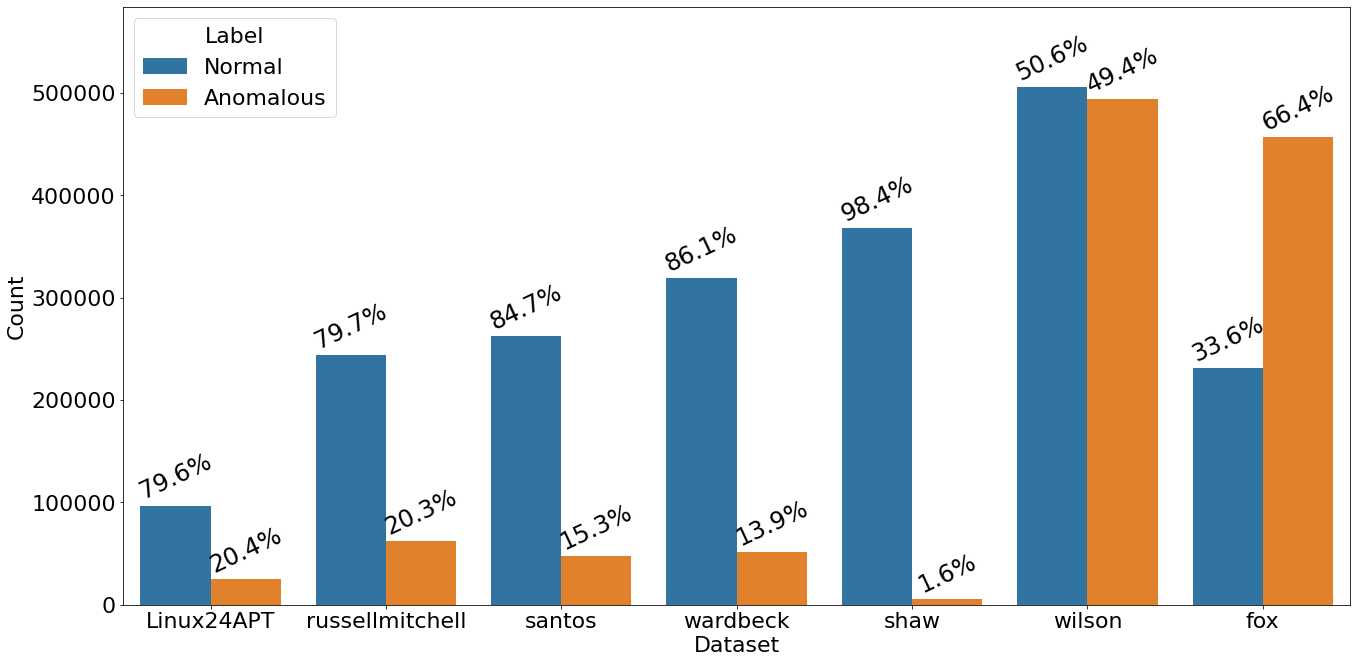

In [10]:
#Convert the dictionary to a DataFrame and reset the index
df = pd.DataFrame(counts).T.reset_index()
df = df.rename(columns={"index": "Dataset"})

# Melt the DataFrame to a long format suitable for Seaborn
# This creates separate rows for 'Normal' and 'Anomalous' counts
df_melted = df.melt(id_vars="Dataset", value_vars=["Normal", "Anomalous"],
                    var_name="Label", value_name="Count")

# --- New section to calculate percentages ---
# Create a dictionary mapping each Dataset to its Total count
total_counts = df.set_index('Dataset')['Total'].to_dict()

# Calculate the percentage for each row in the melted DataFrame
# The percentage is (Count / Total for that Dataset) * 100
df_melted['Percentage'] = df_melted.apply(
    lambda row: (row['Count'] / total_counts[row['Dataset']]) * 100,
    axis=1
)
# --- End of new section ---

# Set the figure size for better readability
plt.style.use('default')
plt.figure(figsize=(22, 11))

# Create the bar plot and store the Axes object
ax = sns.barplot(data=df_melted, x="Dataset", y="Count", hue="Label")

# Add the percentage labels on top of each bar
# ax.containers holds the groups of bars (one group for 'Normal', one for 'Anomalous')
for i, container in enumerate(ax.containers):
    # Get the correct percentage values for the current container (hue)
    # The order of hue is determined by the `value_vars` list in `melt`
    hue_label = ["Normal", "Anomalous"][i]
    labels = [f'{p:.1f}%' for p in df_melted[df_melted['Label'] == hue_label]['Percentage']]
    
    # Attach the labels to the bars in the container
    ax.bar_label(container, labels=labels, label_type='edge', fontsize=_FONT_SIZE, padding=2, rotation=25)
    

# Adjust the y-axis limit to give more space for the labels
ax.set_ylim(top=ax.get_ylim()[1] * 1.1)
ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=_FS)
ax.get_yaxis().set_tick_params(labelsize=_FS)


# Add titles and labels for clarity
# plt.title("Counts of Normal and Anomalous Labels per Dataset with Percentages")
plt.xlabel("Dataset", fontsize=_FS)
plt.ylabel("Count", fontsize=_FS)
plt.legend(title="Label", fontsize=_FS, title_fontsize=_FS)

# Display the plot
plt.show()

# Log Parsing

In [12]:
# function to clean output cells
from IPython.display import clear_output

In [21]:
!pip install logadu
clear_output()

In [22]:
!logadu --help

/home/ahmed.bargady/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Usage: logadu [OPTIONS] COMMAND [ARGS]...

  LogADU - Advanced Log Analysis and Processing

Options:
  --help  Show this message and exit.

Commands:
  parse  Parse log files using specified parser


In [26]:
def parse(file_path):
    try:
        sbp.run(["logadu", "parse", file_path, "--parser", "drain"])
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")

In [27]:
for name, p in tqdm(PATHS.items(), desc="Parsing logs"):
    parse(p)

Parsing logs: 100%|██████████| 7/7 [56:49<00:00, 487.14s/it]


# Temporal Coverage

In [31]:
time_ranges = {}
for name, df in data.items():
    # Ensure the timestamp column is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    min_time = df['timestamp'].min()
    max_time = df['timestamp'].max()
    time_ranges[name] = (min_time, max_time)

for name, (start, end) in time_ranges.items():
    print(f"{name}: Start - {start}, End - {end}")

Linux24APT: Start - 2023-10-01 00:49:18.889000, End - 2024-01-07 10:06:12.096000
russellmitchell: Start - 2022-01-20 13:11:29.233000, End - 2022-01-25 07:01:52.284000
santos: Start - 2022-01-13 14:31:34.934000, End - 2022-01-18 05:43:43.504000
wardbeck: Start - 2022-01-18 13:41:54.232000, End - 2022-01-24 07:18:49.171000
shaw: Start - 2022-01-24 13:30:28.294000, End - 2022-01-31 07:53:08.304000
wilson: Start - 2022-02-02 10:08:32.685000, End - 2022-02-09 07:06:34.081000
fox: Start - 2022-01-14 11:15:31.530000, End - 2022-01-20 06:57:39.321000


In [32]:
datasets = list(time_ranges.keys())
start_times = [r[0] for r in time_ranges.values()]
end_times = [r[1] for r in time_ranges.values()]
durations = [end - start for start, end in zip(start_times, end_times)]

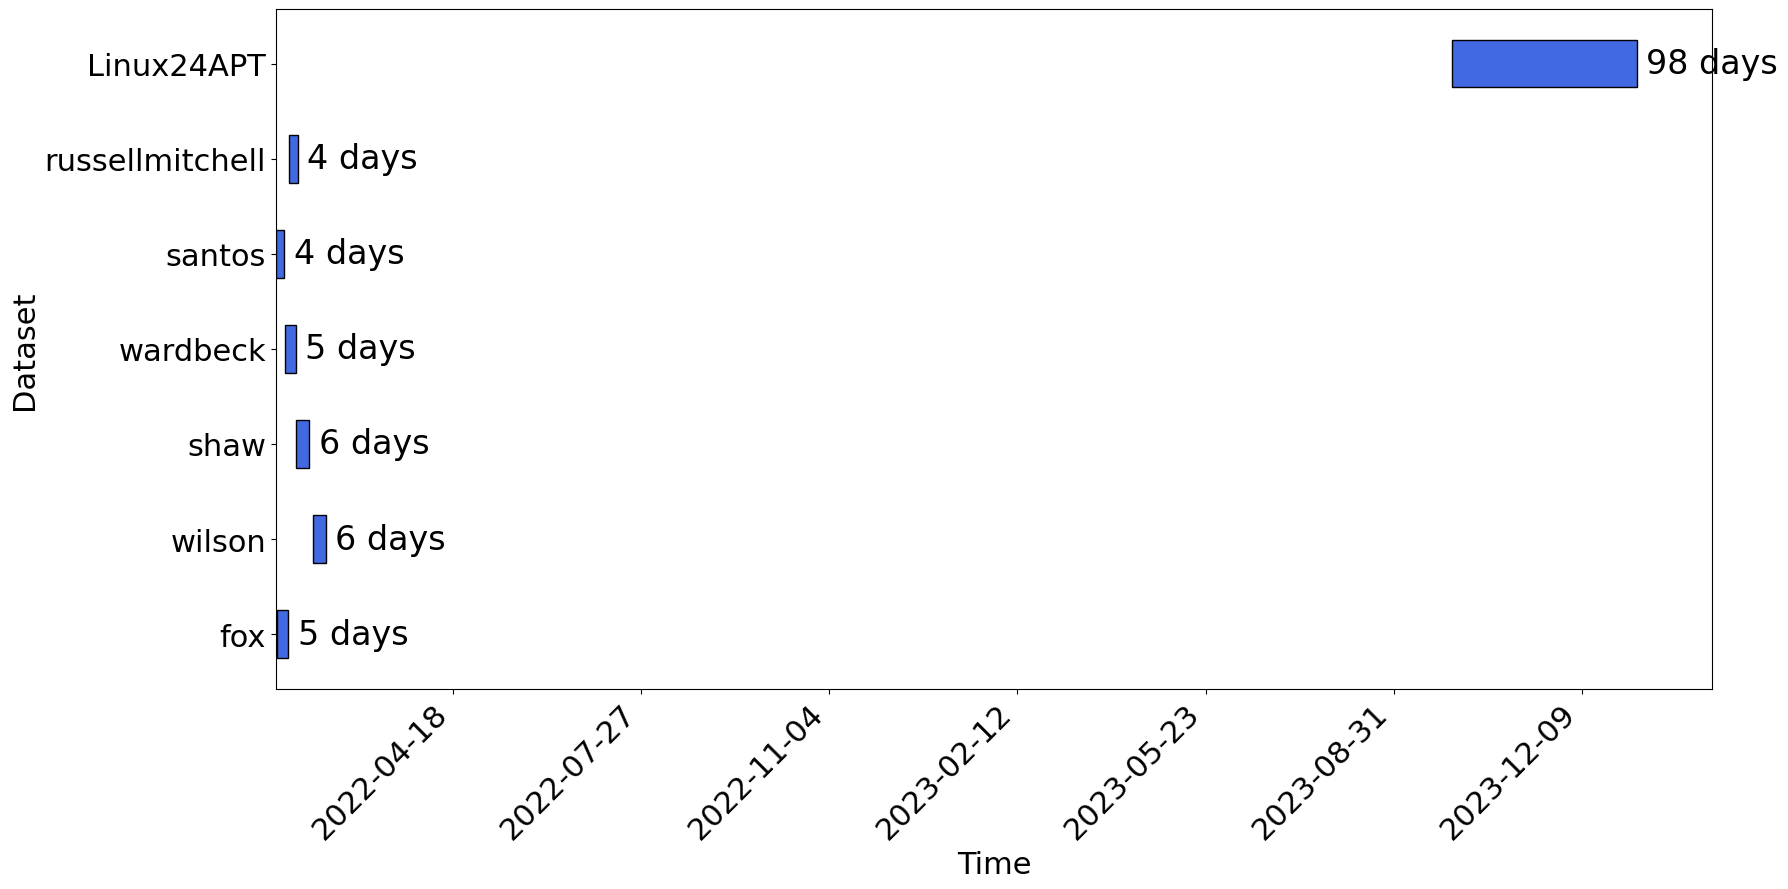

In [33]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(18, 9))

# Plot the horizontal bars
ax.barh(list(time_ranges.keys()), durations, left=start_times, height=0.5, 
        edgecolor="black", color="royalblue")

# Format the x-axis to display dates clearly
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate(rotation=45)

# --- Add day counts to the right of each bar ---
for i, duration in enumerate(durations):
    # Get the total number of days from the timedelta object
    days = duration.days
    
    text_position = end_times[i] + pd.Timedelta(days=5)

    ax.text(text_position, i, f'{days} days',
            va='center',        # Vertically align in the middle of the bar
            ha='left',     # Bold text for emphasis
            # Horizontally align text to the LEFT
            color='black',
            fontsize=_FONT_SIZE)        # Set fontsize for the day count text

max_date = max(end_times)
ax.set_xlim(left=ax.get_xlim()[0], right=max_date + pd.Timedelta(days=40)) # Increased padding for larger font

plt.xlabel('Time', fontsize=_FS)
plt.ylabel('Dataset', fontsize=_FS)

ax.tick_params(axis='both', which='major', labelsize=_FS)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Unique Templates

In [36]:
TEMPLATES_PATHS = {
    name: BASE_PATH / "drain" / f"{name}_all_templates.csv" for name in datasets
}

In [37]:
templates_dfs = {
    name: pd.read_csv(path, low_memory=False) for name, path in TEMPLATES_PATHS.items()
}

<ipython-input-38-5026a6df4128>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(datasets, fontsize=_FS)


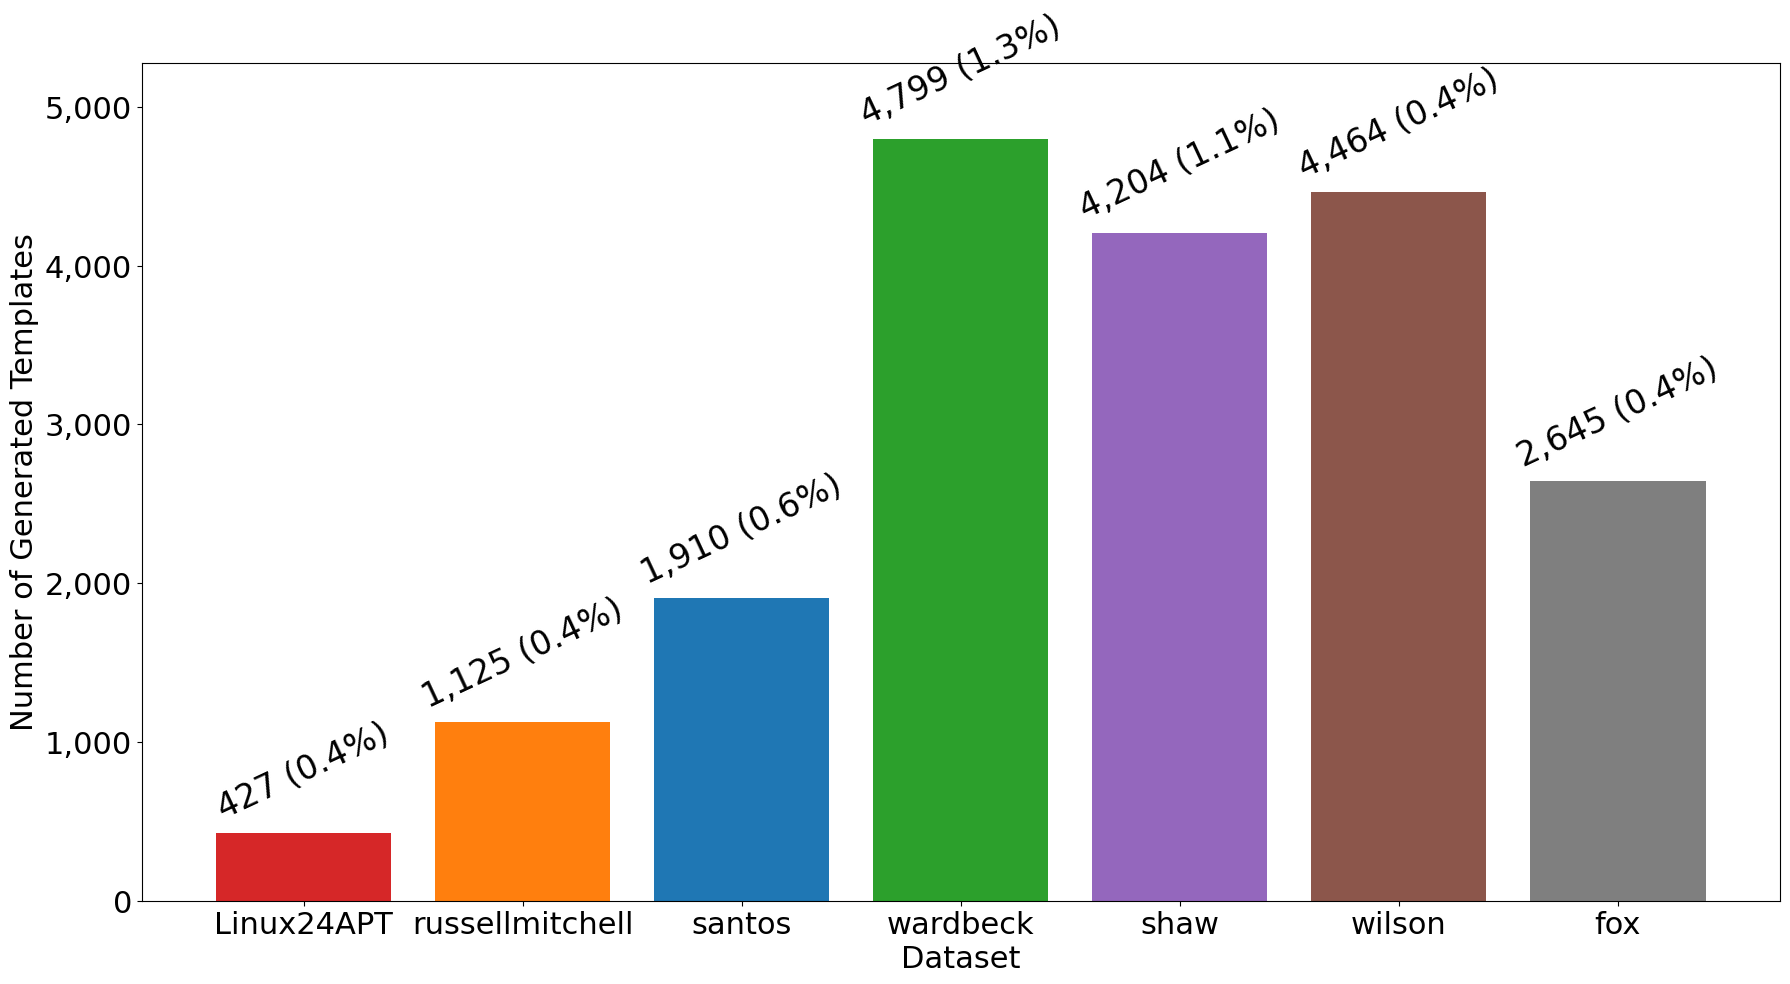

In [38]:
tmpl_counts = [templates_dfs[name].shape[0] for name in datasets]
total_counts = [data[name].shape[0] for name in datasets]

# 2. Create the bar chart
plt.style.use('default')
fig, ax = plt.subplots(figsize=(18, 10))
bars = ax.bar(datasets, tmpl_counts, color=['#d62728','#ff7f0e','#1f77b4', '#2ca02c',
                                            '#9467bd', '#8c564b', '#7f7f7f'])

# 3. Add annotations on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    
    # The text to display: "tmpl_count / str_count"
    annotation_text = f"{tmpl_counts[i]:,} ({tmpl_counts[i] / total_counts[i]*100:.1f}%)"

    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height + (max(tmpl_counts) * 0.01),  # Position text slightly above the bar
        annotation_text,
        ha='center', 
        va='bottom',
        fontsize=_FONT_SIZE,
        # fontweight='bold',
        rotation=25,  # Rotate text for better readability
    )
    
# 4. Customize the plot for clarity
ax.set_xlabel('Dataset', fontsize=_FS)
ax.set_ylabel('Number of Generated Templates', fontsize=_FS)
ax.set_xticklabels(datasets, fontsize=_FS)
# fontsize for y values
ax.get_yaxis().set_tick_params(labelsize=_FS)

ax.get_yaxis(
    ).set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ','))
)

ax.set_ylim(0, max(tmpl_counts) * 1.1)
plt.tight_layout()
plt.show()

# Sequences window size based